# Calculate the steady state for the tilted channels
These are the two dimensional channels.

In [1]:
using Plots
using PGFPlotsX
using LaTeXStrings
using OffsetArrays
using LinearAlgebra
using Statistics
using JLD2
using Dates
using Colors

┌ Info: Recompiling stale cache file /home/jackd/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/jackd/.julia/compiled/v1.1/PGFPlotsX/ckKEQ.ji for PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1184


In [2]:
# Number of cells in the x and y directions.
nx = 300
ny = 300

300

In [3]:
using BrownianDynamics

┌ Info: Recompiling stale cache file /home/jackd/.julia/compiled/v1.1/BrownianDynamics/tUOSF.ji for BrownianDynamics [9aaca010-545f-11e9-1f13-43a2532b2fa8]
└ @ Base loading.jl:1184


## Utility function for initializing the system for the solvers

## Single channel potential

In [4]:
xx = range(0,stop=1,length=nx)  # Centers of the finite volume cells in the x direction.
yy = range(-1,stop=1,length=ny)  # Centers of the finite volume cells in the y direction.
dx,dy = step(xx),step(yy)
## Choose parameters.
Tc = 1.0; Th = 1.0; coupling = 0.1; p = [10,8,20]
@time u0,params_single_channel = create_system(xx,yy,Tc,Th,coupling,p;potential_type=:tilted_channel);

  1.626913 seconds (7.37 M allocations: 444.744 MiB, 12.74% gc time)


norm([du; sum(u[1:nn]) * dx * dy - 1]) / nn = 5.454793929495712e-7
 22.377042 seconds (23.78 M allocations: 4.998 GiB, 6.29% gc time)
sum(Jx) * dx * dy = 0.0007170374302042717
(norm(flux!(copy(u0), u_steady_single_channel, params_single_channel, 0)) / nx) / ny = 4.2092652915667954e-8


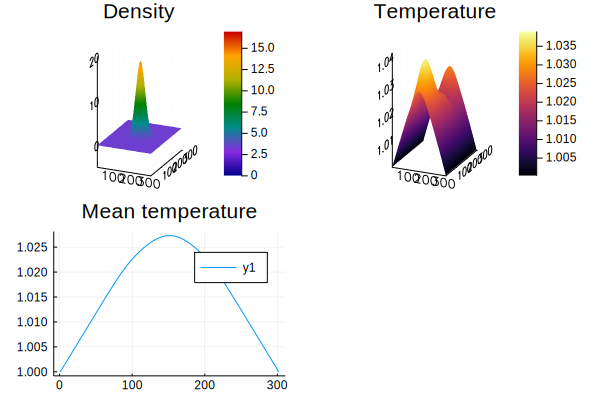

In [5]:
## Solve for the steady state.
@time u_steady_single_channel = solve_steady_state(u0,params_single_channel;maxiters=5,steadytol=1e-14)
Jx,Jy = density_current((xx,yy),u_steady_single_channel,params_single_channel)
@show sum(Jx)*dx*dy
@show norm(flux!(copy(u0),u_steady_single_channel,params_single_channel,0))/nx/ny
## Visualize.
p1 = surface(reshape(u_steady_single_channel[1:nx*ny],nx,ny),color=:darktest)
title!("Density")
p2 = surface(reshape(u_steady_single_channel[nx*ny+1:end],nx,ny))
title!("Temperature")
Tsol_single_channel = reshape(u_steady_single_channel[(nx*ny+1):end],nx,ny)
Tsol_single_channel = [ones(nx)*Th Tsol_single_channel ones(nx)*Tc]
p3 = plot([mean(Tsol_single_channel[:,i]) for i in 1:nx+2])
title!("Mean temperature")
plot(p1,p2,p3)

## Double channel potential

In [6]:
## Choose parameters.
Tc = 1.0; Th = 1.0; coupling = 1.0; p = [2,3,3,10,10,15]
@time u0,params_double_channel = create_system(xx,yy,Tc,Th,coupling,p;potential_type=:double_channel);

  0.325934 seconds (1.49 M allocations: 158.248 MiB, 6.61% gc time)


norm([du; sum(u[1:nn]) * dx * dy - 1]) / nn = 0.00038020716843881506
 15.860126 seconds (3.79 k allocations: 3.933 GiB, 7.18% gc time)
(norm(flux!(copy(u0), u_steady_double_channel, params_double_channel, 0)) / nx) / ny = 2.7942628316063405e-6


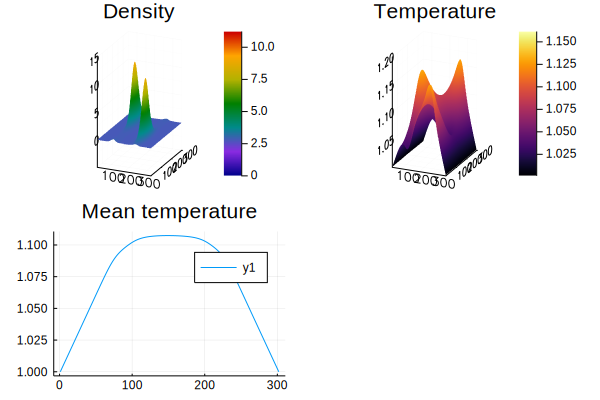

In [7]:
## Solve for the steady state.
@time u_steady_double_channel = solve_steady_state(u0,params_double_channel;maxiters=5,steadytol=1e-14)
@show norm(flux!(copy(u0),u_steady_double_channel,params_double_channel,0))/nx/ny
## Visualize.
p1 = surface(reshape(u_steady_double_channel[1:nx*ny],nx,ny),color=:darktest)
title!("Density")
p2 = surface(reshape(u_steady_double_channel[nx*ny+1:end],nx,ny))
title!("Temperature")
Tsol_double_channel = reshape(u_steady_double_channel[(nx*ny+1):end],nx,ny)
Tsol_double_channel = [ones(nx)*Th Tsol_double_channel ones(nx)*Tc]
p3 = plot([mean(Tsol_double_channel[:,i]) for i in 1:nx+2])
title!("Mean temperature")
plot(p1,p2,p3)

## Find the steady state current for multiple values of the force and the coupling constant

In [8]:
LinearAlgebra.BLAS.set_num_threads(1)

In [9]:
nforces = 8
ncouplings = 4
force_vec = range(0,stop=1,length=nforces)
# coupling_vec = 5*10 .^ range(0,stop=-2.5,length=ncouplings) |> reverse
coupling_vec = [5.0 0.1 0.02]
p = [3,4,15]*1.0
dx,dy = step(xx),step(yy)

Jx_save = zeros(Float64,length(force_vec),length(coupling_vec))
@time Threads.@threads for i in 1:length(force_vec)
    force = force_vec[i]
    for (j,coupling) in enumerate(coupling_vec)
        coupling = coupling_vec[j]
        p = [force,4,15]*1.0
        u0,params_single_channel = create_system(xx,yy,Tc,Th,coupling,p;potential_type=:tilted_channel                                            )
        solve_steady_state(u0,params_single_channel;maxiters=5,steadytol=1e-8,print_residual=false)
        Jx = params_single_channel.Jx
        Jy = params_single_channel.Jy
        
        Jx_save[i,j] = sum(Jx)*dx*dy
    end
end

162.569387 seconds (15.50 M allocations: 95.620 GiB, 5.21% gc time)


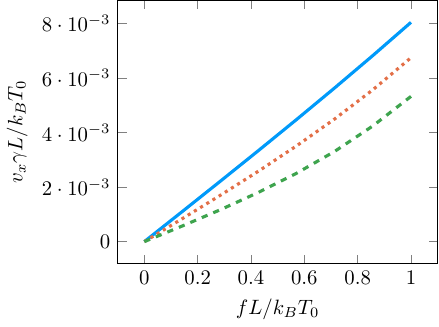

In [10]:
plot_colors = PlotThemes.palette(:default)
p = @pgf Axis(
    {
        width="7cm",
        xlabel=L"fL/k_{B}T_{0}",
        ylabel=L"v_{x}\gamma L/k_{B}T_{0}",
        scaled_y_ticks="false"
    },
    PlotInc({mark="none",line_width=1.5,
             color=color(plot_colors[1])
             },
            Table(force_vec,Jx_save[:,1])),
    PlotInc({mark="none",line_width=1.5,
             "dotted",
             color=color(plot_colors[2])
             },
            Table(force_vec,Jx_save[:,2])),
    PlotInc({mark="none",line_width=1.5,
             "dashed",
             color=color(plot_colors[3])},
            Table(force_vec,Jx_save[:,3])),  
)

In [11]:
date = Dates.today()

pgfsave("data/figures/steady_drift.tex",p,include_preamble=false)
pgfsave("data/figures/steady_drift.pdf",p)

In [12]:
# Save data for the single channel steady state.
date = Dates.today()

xx = range(0,stop=1,length=nx)
yy = range(-1,stop=1,length=ny)
fname = "data/steady_state_single_channel"
V_equilibrium = [x^2 for x in xx, y in yy]
u_steady = collect(u_steady_single_channel)
params = params_single_channel
T0 = Tc
@save "$(fname)$(date).jld" u_steady params xx yy T0 V_equilibrium
@save "$(fname).jld" u_steady params xx yy T0 V_equilibrium

In [13]:
# Save data for the double channel steady state.
date = Dates.today()

xx = range(0,stop=1,length=nx)
yy = range(-1,stop=1,length=ny)
fname = "data/steady_state_double_channel"
V_equilibrium = [x^2 for x in xx, y in yy]
u_steady = collect(u_steady_double_channel)
params = params_double_channel
T0 = Tc

@save "$(fname).jld" u_steady params xx yy T0 V_equilibrium
@save "$(fname)$(date).jld" u_steady params xx yy T0 V_equilibrium

In [14]:
# Save data for the steady state drift as a function of coupling strength and force.
date = Dates.today()

fname = "data/drift"
@save "$(fname)$(date).jld" Jx_save coupling_vec force_vec
@save "$(fname)$(date).jld" Jx_save coupling_vec force_vec

# Use the external plotting files to make a prettier figure of the steady state
The files include a lot more fomatting than is necessary for this notebook. The end result is saved into /data/figures.

In [15]:
run(`julia data/stream/plot_tilted_channel_single.jl`)
run(`julia data/stream/plot_tilted_channel_double.jl`)

Process(`julia data/stream/plot_tilted_channel_double.jl`, ProcessExited(0))